# Insight into the HighD dataset

## Brief Introduction to HighD

HighD is a dataset collected by Aachen University, German. This dataset "includes post-processed trajectories of 110 000 vehicles including cars and trucks extracted from drone video recordings at German highways around Cologne during 2017 and 2018. At six different locations, 60 recordings were made with an average length of 17 minutes (16.5 h in total) covering a road segment of about 420 m length. Each vehicle is visible for a median duration of 13.6 s."

Due to the LICENSE of highD dataset, this repository cannot distribute the dataset to the public. To apply for this dataset, please visit https://www.highd-dataset.com. The details about the data format can be obtained from [here](https://www.highd-dataset.com/format).

**This script intends to provide some visualized insight into the dataset.**

```tex
@inproceedings{krajewski2018highd,
  title={The highd dataset: A drone dataset of naturalistic vehicle trajectories on german highways for validation of highly automated driving systems},
  author={Krajewski, Robert and Bock, Julian and Kloeker, Laurent and Eckstein, Lutz},
  booktitle={2018 21st International Conference on Intelligent Transportation Systems (ITSC)},
  pages={2118--2125},
  year={2018},
  organization={IEEE}
}
```

## Specialties about HighD dataset

HighD is the first trajectory dataset published by LevelX. Its annotations are slightly different from its siblings InD, RounD.

- **coordinate system**: The coordinate system of the HighD dataset is unique. As is shown in the following figure. It starts from the left-upper position of the road. If you want to restore the trajectories, it will be better reverse the y-axis (use $(x,-y)$ instead of $(x,y)$).

- **location of vehicles**: The HighD dataset take left-upper corner of the bounding box to represent the location of every vehicle.

- **disaligned original points**: The original points of coordinate system are different from file to file, even for the same map.

*FYI. There is no speed limit to highway in Germany.*

## Match data files to maps

According to meta records:

- track files 01-03 are recorded in location 2 (denote map as highD_0).
- track files 04-06 are recorded in location 3 (denote as highD_1).
- track files 07-10 are recorded in location 4 (denote as highD_2).
- track files 11-14, 25-57 are recorded in location 1 (denote as highD_3).
- track files 15-24 are recorded in location 5 (denote as highD_4).
- track files 58-60 are recorded in location 6 (denote as highD_5).

## Data Visualization

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
global data_path, vehicle_type
data_path = "/data/HighD/highD/data"
vehicle_type = ["Car", "Truck"]
config = json.load(open("../data/configs/highD.config","r"))

In [4]:
def plot_trajectories(file_ids):
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        xCenter = np.array(df["x"]) + np.array(df["width"]) / 2
        yCenter = -np.array(df["y"]) - np.array(df["height"]) / 2
        plt.scatter(xCenter, yCenter, s=0.01, c="deepskyblue")
    plt.xlabel("(m)")
    plt.ylabel("(m)")
    plt.show()

In [5]:
def plot_passing_time(file_ids):
    car_passing_time = []
    truck_passing_time = []
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id), index_col="id")
        vehicle_ids = df["id"].unique()
        for v_id in vehicle_ids:
            df_sub = df[df["id"] == v_id].reset_index()
            if abs(df_sub.iloc[-1]["x"] - df_sub.iloc[0]["x"]) < 300:
                pass
            else:
                if df_meta.loc[v_id, "class"] == "Car":
                    car_passing_time.append((df_sub.iloc[-1]["frame"]-df_sub.iloc[0]["frame"])/25)
                else:
                    truck_passing_time.append((df_sub.iloc[-1]["frame"]-df_sub.iloc[0]["frame"])/25)
    print("Average passing time of the cars is %.03f s." % np.mean(car_passing_time))
    print("Maximum passing time of the cars is %.03f s." % np.max(car_passing_time))
    print("STD of the cars' passing time is %.03f s." % np.std(car_passing_time))
    print("Average passing time of the trucks is %.03f s." % np.mean(truck_passing_time))
    print("Max passing time of the trucks is %.03f s." % np.max(truck_passing_time))
    print("STD of the trucks' passing time is %.03f s." % np.std(truck_passing_time))
    sns.distplot(car_passing_time, label="car", color="cornflowerblue")
    sns.distplot(truck_passing_time, label="truck", color="salmon")
    plt.xlabel("Passing time")
    plt.legend()
    plt.show()

In [6]:
def plot_speed_distribution(file_ids):
    car_velocity = []
    truck_velocity = []
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id))
        car_id = list(df_meta[df_meta["class"] == "Car"]["id"])
        df_car = df[df["id"].isin(car_id)]
        car_velocity += list(np.sqrt(np.square(df_car["xVelocity"])+np.square(df_car["yVelocity"])))
        truck_id = list(df_meta[df_meta["class"] == "Truck"]["id"])
        df_truck = df[df["id"].isin(truck_id)]
        truck_velocity += list(np.sqrt(np.square(df_truck["xVelocity"])+np.square(df_truck["yVelocity"])))
    
    print("Average speed of the cars is %.03f s." % np.mean(car_velocity))
    print("Maximum speed of the cars is %.03f s." % np.max(car_velocity))
    print("Minimum speed of the cars is %.03f s." % np.max(car_velocity))
    print("STD of the cars' speed is %.03f s." % np.std(car_velocity))
    print("Average speed of the trucks is %.03f s." % np.mean(truck_velocity))
    print("Maximum speed of the trucks is %.03f s." % np.max(truck_velocity))
    print("Minimum speed of the trucks is %.03f s." % np.max(truck_velocity))
    print("STD of the trucks speed is %.03f s." % np.std(truck_velocity))
    sns.distplot(car_velocity, label="car", color="cornflowerblue")
    sns.distplot(truck_velocity, label="truck", color="salmon")
    plt.xlabel("Speed distribution of every file")
    plt.legend()
    plt.show()

In [7]:
def count_lane_changing(file_ids):
    for id in file_ids:
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id), index_col="id")
        change_times = [0,0,0]
        for i in range(3):
            change_times[i] = np.sum(df_meta["numLaneChanges"] == i)
        print("File id: %d has %d tracks in total." % (id, len(df_meta)))
        print("\t%d vehicles never changes lane." % change_times[0])
        print("\t%d vehicles change lane for once." % change_times[1])
        print("\t%d vehicles change lane for twice." % change_times[2])

In [8]:
def plot_traffic_density(file_ids):
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id))
        car_id = list(df_meta[df_meta["class"] == "Car"]["id"])
        df_car = df[df["id"].isin(car_id)]
        truck_id = list(df_meta[df_meta["class"] == "Truck"]["id"])
        df_truck = df[df["id"].isin(truck_id)]
        last_frame = np.max(df["frame"])
        count_car = []
        count_truck = []
        for f in range(last_frame):
            count_car.append(len(df_car[df_car["frame"]==f+1]))
            count_truck.append(len(df_truck[df_truck["frame"]==f+1]))
        print("File id: %d" % id)
        sns.lineplot(list(range(1, last_frame+1)), count_car, label="car")
        sns.lineplot(list(range(1, last_frame+1)), count_truck, label="truck")
        plt.xlabel("Frame")
        plt.legend()
        plt.show()

### highD_0 (location 2)

#### Trajectories

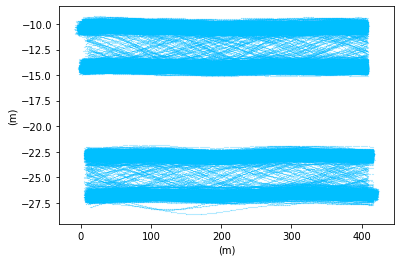

In [9]:
plot_trajectories(config["H_highD_0_DEU"]["track_files"])

#### Average Passing Time

Average passing time of the cars is 12.456 s.
Maximum passing time of the cars is 19.160 s.
STD of the cars' passing time is 1.928 s.
Average passing time of the trucks is 17.156 s.
Max passing time of the trucks is 20.360 s.
STD of the trucks' passing time is 1.084 s.


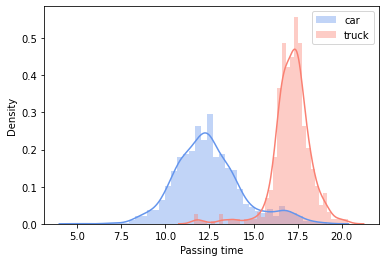

In [10]:
plot_passing_time(config["H_highD_0_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 32.531 s.
Maximum speed of the cars is 65.200 s.
Minimum speed of the cars is 65.200 s.
STD of the cars' speed is 5.037 s.
Average speed of the trucks is 23.456 s.
Maximum speed of the trucks is 35.751 s.
Minimum speed of the trucks is 35.751 s.
STD of the trucks speed is 1.492 s.


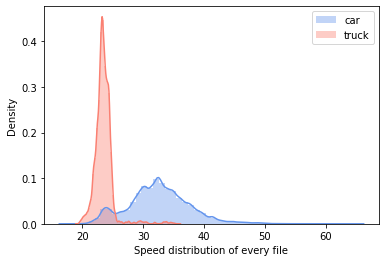

In [11]:
plot_speed_distribution(config["H_highD_0_DEU"]["track_files"])

#### Count Number of Lane Changing

In [12]:
count_lane_changing(config["H_highD_0_DEU"]["track_files"])

File id: 1 has 1047 tracks in total.
	913 vehicles never changes lane.
	129 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 2 has 1113 tracks in total.
	993 vehicles never changes lane.
	115 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 3 has 914 tracks in total.
	799 vehicles never changes lane.
	111 vehicles change lane for once.
	4 vehicles change lane for twice.


#### Traffic Density

File id: 1


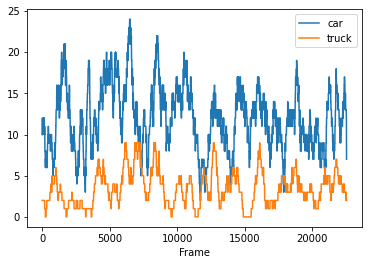

File id: 2


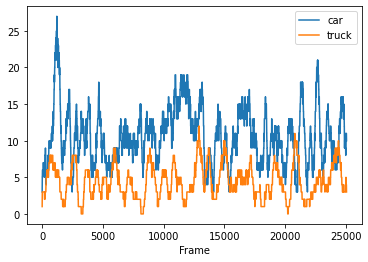

File id: 3


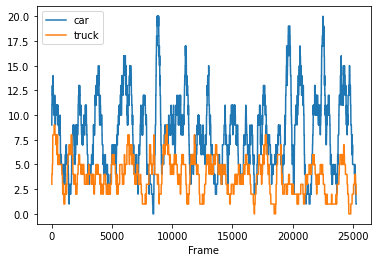

In [13]:
plot_traffic_density(config["H_highD_0_DEU"]["track_files"])

### highD_1 (location 3)

#### Trajectories

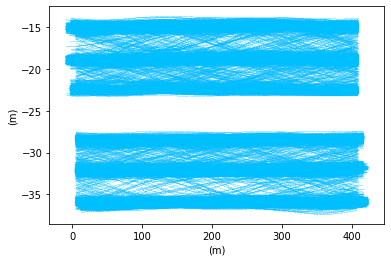

In [14]:
plot_trajectories(config["H_highD_1_DEU"]["track_files"])

#### Average Passing Time

Average passing time of the cars is 12.304 s.
Maximum passing time of the cars is 18.840 s.
STD of the cars' passing time is 1.900 s.
Average passing time of the trucks is 16.389 s.
Max passing time of the trucks is 19.200 s.
STD of the trucks' passing time is 1.098 s.


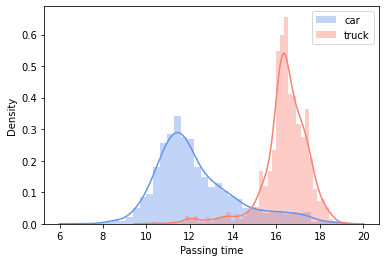

In [15]:
plot_passing_time(config["H_highD_1_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 33.112 s.
Maximum speed of the cars is 57.971 s.
Minimum speed of the cars is 57.971 s.
STD of the cars' speed is 4.930 s.
Average speed of the trucks is 24.662 s.
Maximum speed of the trucks is 39.602 s.
Minimum speed of the trucks is 39.602 s.
STD of the trucks speed is 1.701 s.


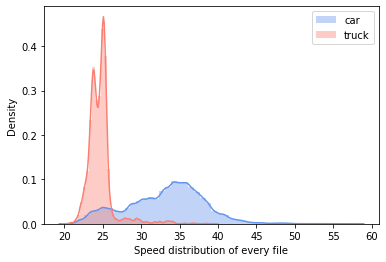

In [16]:
plot_speed_distribution(config["H_highD_1_DEU"]["track_files"])

#### Count Number of Lane Changing

In [17]:
count_lane_changing(config["H_highD_1_DEU"]["track_files"])

File id: 4 has 1163 tracks in total.
	922 vehicles never changes lane.
	223 vehicles change lane for once.
	17 vehicles change lane for twice.
File id: 5 has 1216 tracks in total.
	964 vehicles never changes lane.
	231 vehicles change lane for once.
	21 vehicles change lane for twice.
File id: 6 has 1368 tracks in total.
	1090 vehicles never changes lane.
	261 vehicles change lane for once.
	14 vehicles change lane for twice.


#### Traffic Density

File id: 4


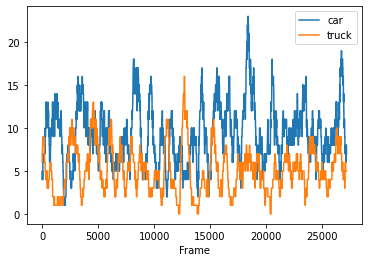

File id: 5


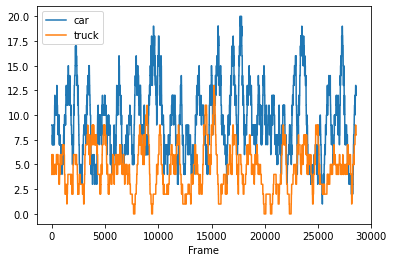

File id: 6


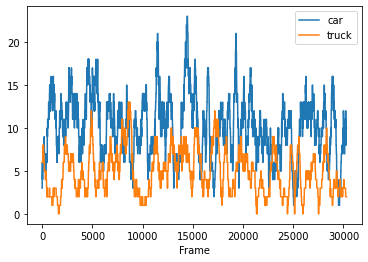

In [18]:
plot_traffic_density(config["H_highD_1_DEU"]["track_files"])

### highD_2 (location 4)

#### Trajectories

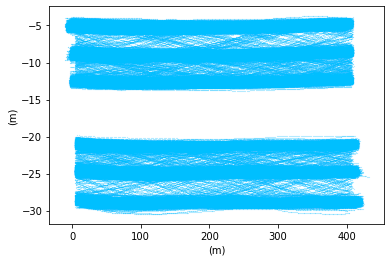

In [19]:
plot_trajectories(config["H_highD_2_DEU"]["track_files"])

Average passing time of the cars is 11.255 s.
Maximum passing time of the cars is 21.080 s.
STD of the cars' passing time is 1.844 s.
Average passing time of the trucks is 15.918 s.
Max passing time of the trucks is 22.440 s.
STD of the trucks' passing time is 1.252 s.


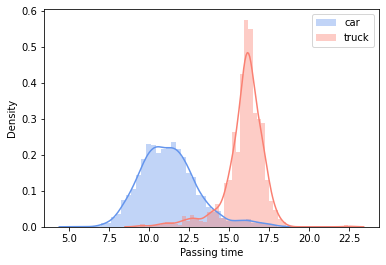

In [20]:
plot_passing_time(config["H_highD_2_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 35.968 s.
Maximum speed of the cars is 68.280 s.
Minimum speed of the cars is 68.280 s.
STD of the cars' speed is 5.768 s.
Average speed of the trucks is 25.001 s.
Maximum speed of the trucks is 44.381 s.
Minimum speed of the trucks is 44.381 s.
STD of the trucks speed is 2.071 s.


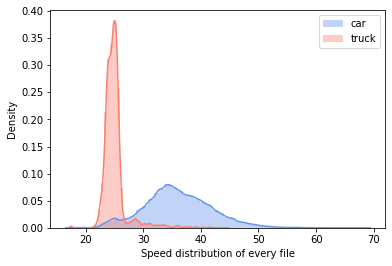

In [21]:
plot_speed_distribution(config["H_highD_2_DEU"]["track_files"])

#### Count Number of Lane Changing

In [22]:
count_lane_changing(config["H_highD_2_DEU"]["track_files"])

File id: 7 has 855 tracks in total.
	725 vehicles never changes lane.
	127 vehicles change lane for once.
	3 vehicles change lane for twice.
File id: 8 has 1620 tracks in total.
	1352 vehicles never changes lane.
	254 vehicles change lane for once.
	14 vehicles change lane for twice.
File id: 9 has 1420 tracks in total.
	1191 vehicles never changes lane.
	216 vehicles change lane for once.
	11 vehicles change lane for twice.
File id: 10 has 856 tracks in total.
	723 vehicles never changes lane.
	125 vehicles change lane for once.
	8 vehicles change lane for twice.


File id: 7


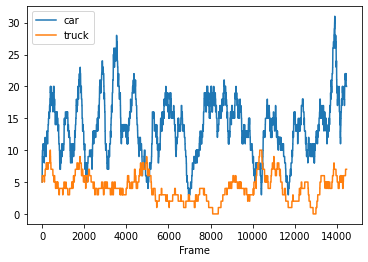

File id: 8


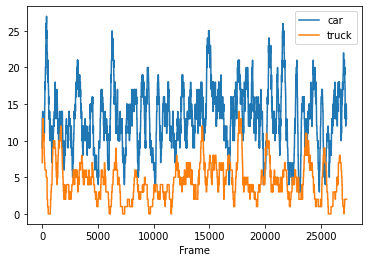

File id: 9


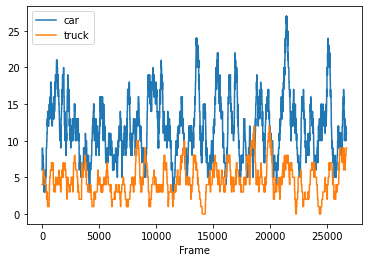

File id: 10


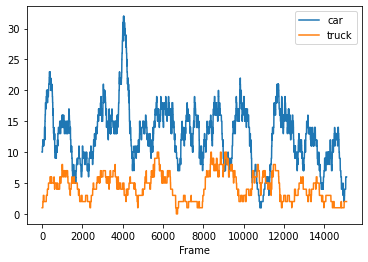

In [23]:
plot_traffic_density(config["H_highD_2_DEU"]["track_files"])

### highD_3 (location 1)

#### Trajectories

The trajectory visualization of location 1 proofs that the origin points of the coordinate system are different from file to file.

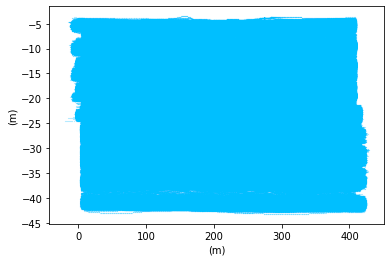

In [24]:
plot_trajectories(config["H_highD_3_DEU"]["track_files"])

Average passing time of the cars is 14.200 s.
Maximum passing time of the cars is 88.640 s.
STD of the cars' passing time is 5.046 s.
Average passing time of the trucks is 17.485 s.
Max passing time of the trucks is 90.480 s.
STD of the trucks' passing time is 4.978 s.


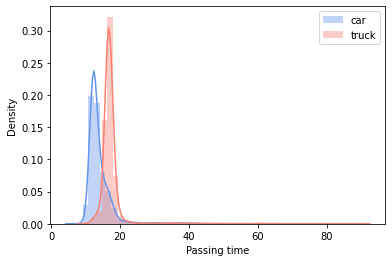

In [25]:
plot_passing_time(config["H_highD_3_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 28.699 s.
Maximum speed of the cars is 57.300 s.
Minimum speed of the cars is 57.300 s.
STD of the cars' speed is 7.141 s.
Average speed of the trucks is 23.117 s.
Maximum speed of the trucks is 44.060 s.
Minimum speed of the trucks is 44.060 s.
STD of the trucks speed is 4.291 s.


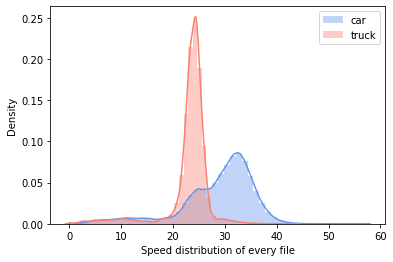

In [26]:
plot_speed_distribution(config["H_highD_3_DEU"]["track_files"])

#### Count Number of Lane Changing

In [27]:
count_lane_changing(config["H_highD_3_DEU"]["track_files"])

File id: 11 has 1776 tracks in total.
	1634 vehicles never changes lane.
	138 vehicles change lane for once.
	4 vehicles change lane for twice.
File id: 12 has 2728 tracks in total.
	2527 vehicles never changes lane.
	193 vehicles change lane for once.
	7 vehicles change lane for twice.
File id: 13 has 2949 tracks in total.
	2637 vehicles never changes lane.
	299 vehicles change lane for once.
	12 vehicles change lane for twice.
File id: 14 has 2844 tracks in total.
	2571 vehicles never changes lane.
	265 vehicles change lane for once.
	8 vehicles change lane for twice.
File id: 25 has 2850 tracks in total.
	2709 vehicles never changes lane.
	136 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 26 has 2708 tracks in total.
	2497 vehicles never changes lane.
	201 vehicles change lane for once.
	8 vehicles change lane for twice.
File id: 27 has 2599 tracks in total.
	2348 vehicles never changes lane.
	237 vehicles change lane for once.
	14 vehicles change lane f

File id: 11


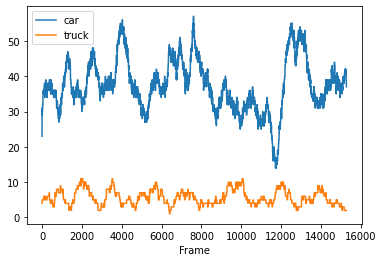

File id: 12


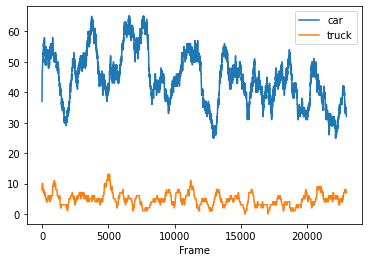

File id: 13


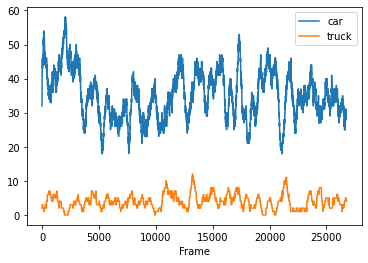

File id: 14


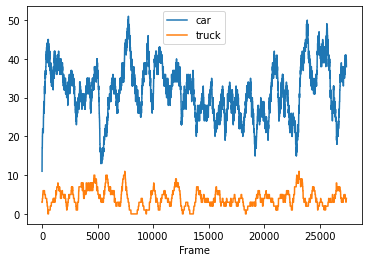

File id: 25


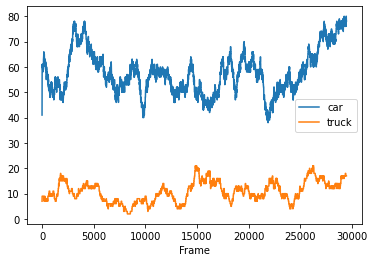

File id: 26


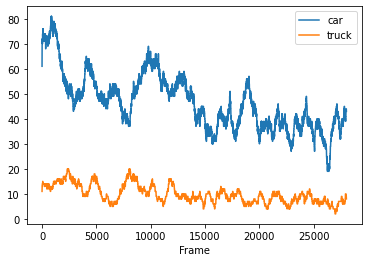

File id: 27


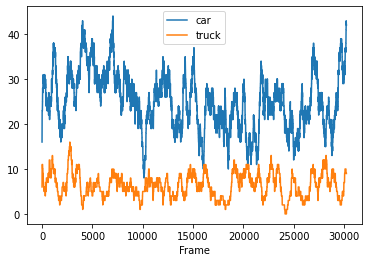

File id: 28


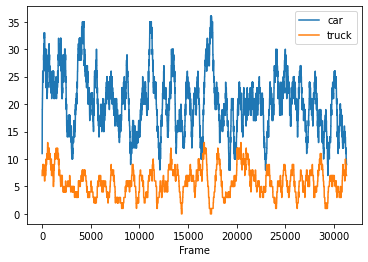

File id: 29


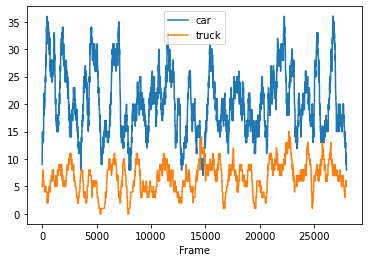

File id: 30


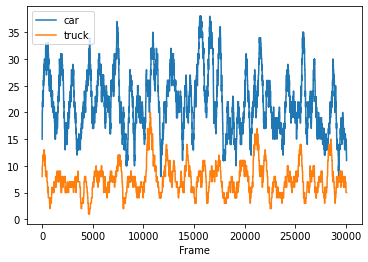

File id: 31


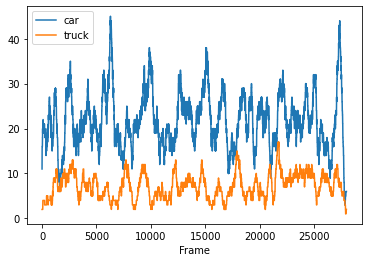

File id: 32


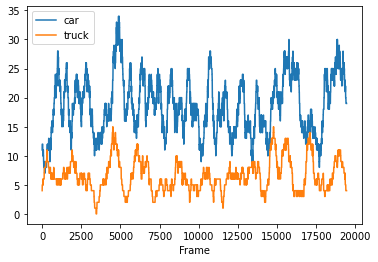

File id: 33


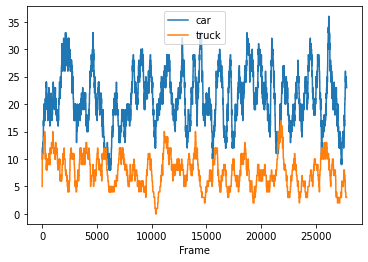

File id: 34


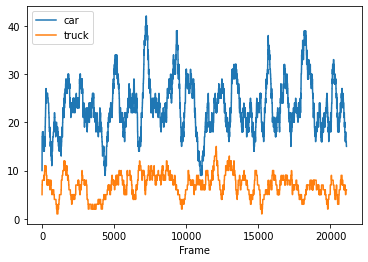

File id: 35


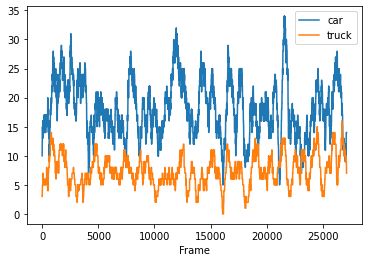

File id: 36


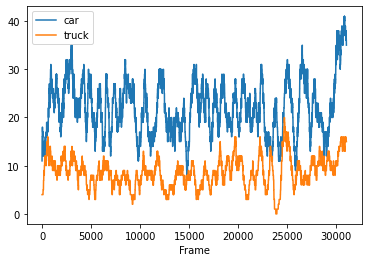

File id: 37


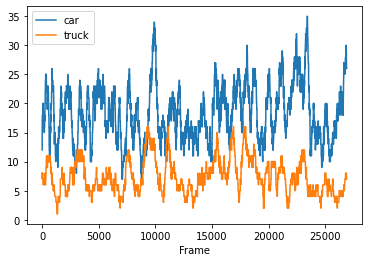

File id: 38


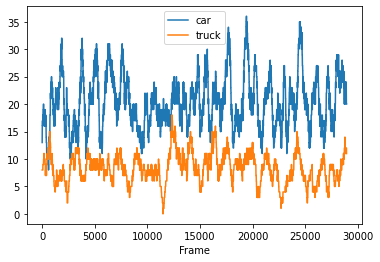

File id: 39


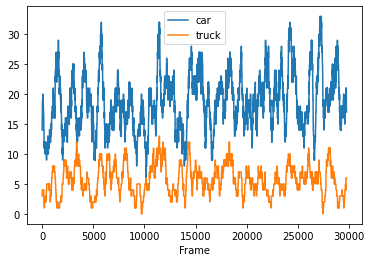

File id: 40


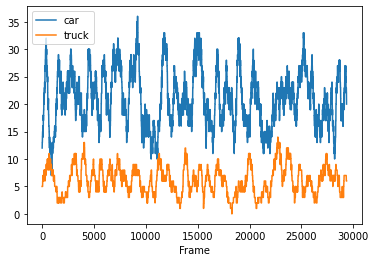

File id: 41


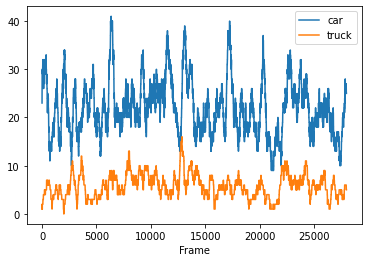

File id: 42


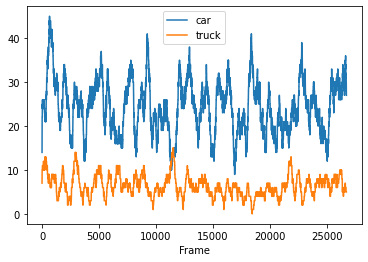

File id: 43


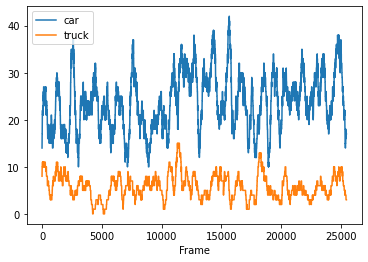

File id: 44


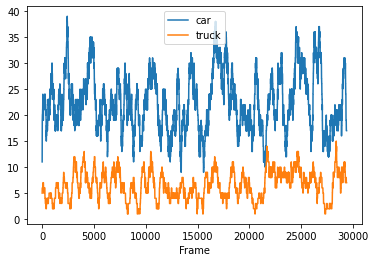

File id: 45


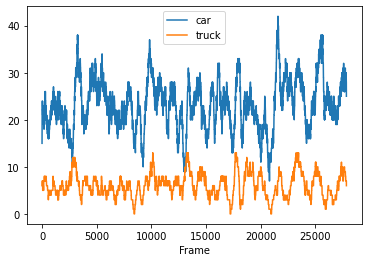

File id: 46


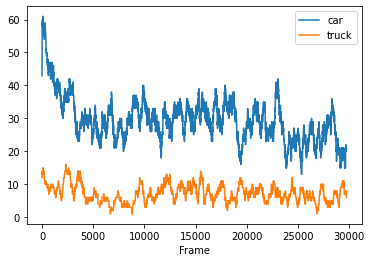

File id: 47


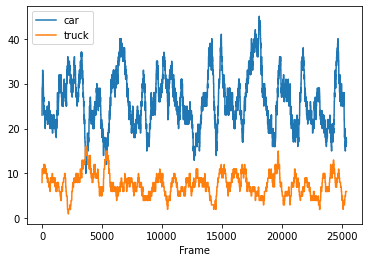

File id: 48


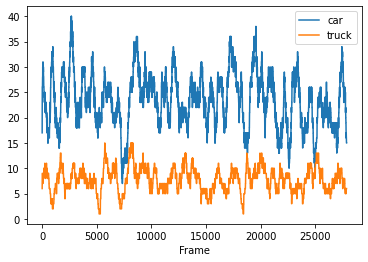

File id: 49


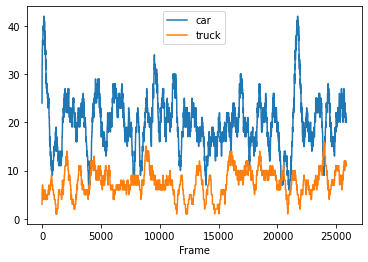

File id: 50


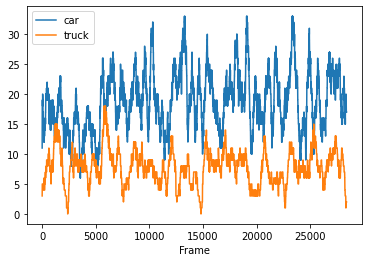

File id: 51


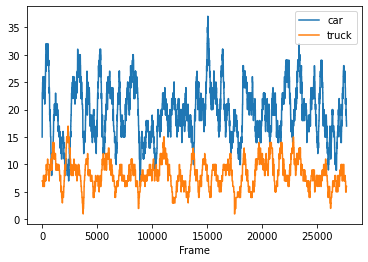

File id: 52


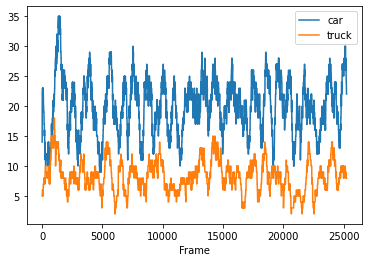

File id: 53


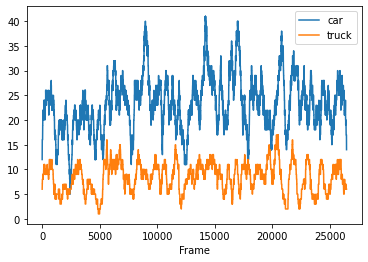

File id: 54


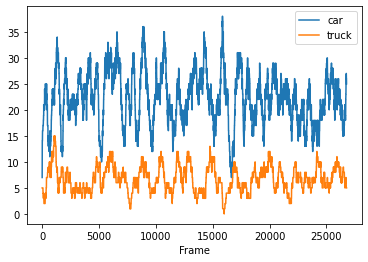

File id: 55


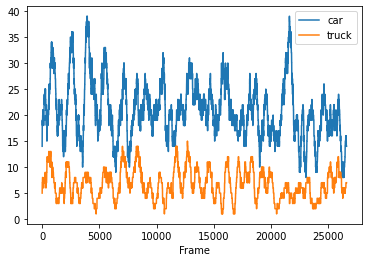

File id: 56


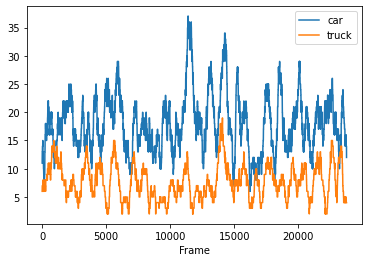

File id: 57


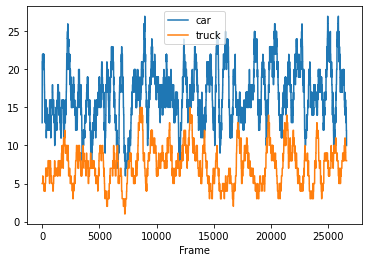

In [28]:
plot_traffic_density(config["H_highD_3_DEU"]["track_files"])

### highD_4 (location 5)

#### Trajectories

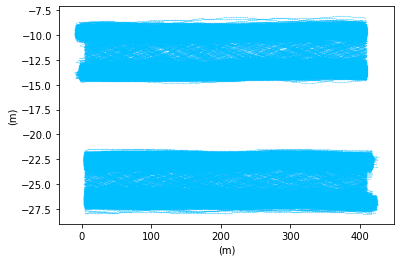

In [29]:
plot_trajectories(config["H_highD_4_DEU"]["track_files"])

#### Average Passing Time

Average passing time of the cars is 12.912 s.
Maximum passing time of the cars is 20.640 s.
STD of the cars' passing time is 2.035 s.
Average passing time of the trucks is 16.611 s.
Max passing time of the trucks is 20.880 s.
STD of the trucks' passing time is 1.131 s.


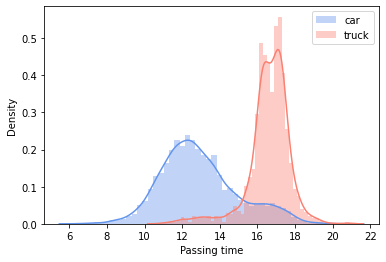

In [30]:
plot_passing_time(config["H_highD_4_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 31.602 s.
Maximum speed of the cars is 64.000 s.
Minimum speed of the cars is 64.000 s.
STD of the cars' speed is 5.017 s.
Average speed of the trucks is 24.321 s.
Maximum speed of the trucks is 39.220 s.
Minimum speed of the trucks is 39.220 s.
STD of the trucks speed is 1.781 s.


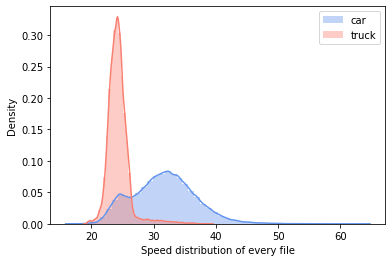

In [31]:
plot_speed_distribution(config["H_highD_4_DEU"]["track_files"])

#### Count Number of Lane Changing

In [32]:
count_lane_changing(config["H_highD_4_DEU"]["track_files"])

File id: 15 has 922 tracks in total.
	807 vehicles never changes lane.
	110 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 16 has 998 tracks in total.
	858 vehicles never changes lane.
	135 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 17 has 977 tracks in total.
	850 vehicles never changes lane.
	122 vehicles change lane for once.
	5 vehicles change lane for twice.
File id: 18 has 607 tracks in total.
	532 vehicles never changes lane.
	71 vehicles change lane for once.
	4 vehicles change lane for twice.
File id: 19 has 999 tracks in total.
	850 vehicles never changes lane.
	140 vehicles change lane for once.
	9 vehicles change lane for twice.
File id: 20 has 1199 tracks in total.
	1060 vehicles never changes lane.
	135 vehicles change lane for once.
	4 vehicles change lane for twice.
File id: 21 has 1077 tracks in total.
	942 vehicles never changes lane.
	127 vehicles change lane for once.
	8 vehicles change lane for twice.
File

File id: 15


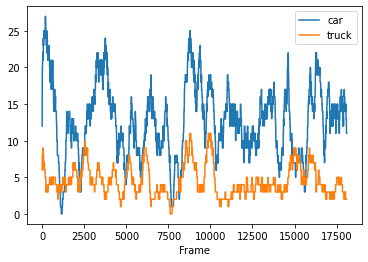

File id: 16


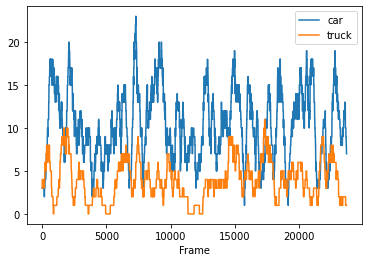

File id: 17


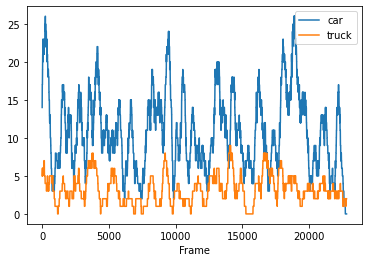

File id: 18


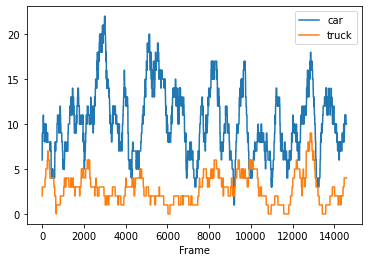

File id: 19


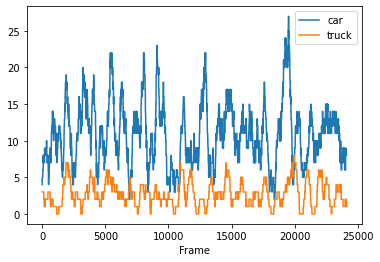

File id: 20


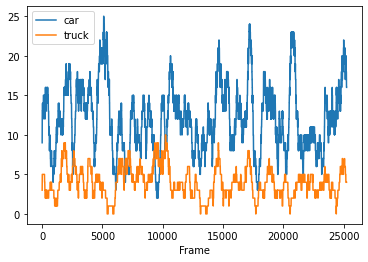

File id: 21


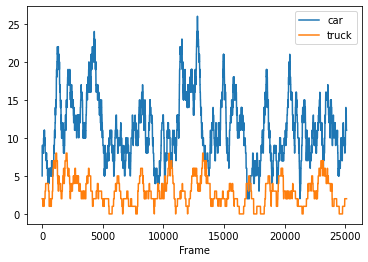

File id: 22


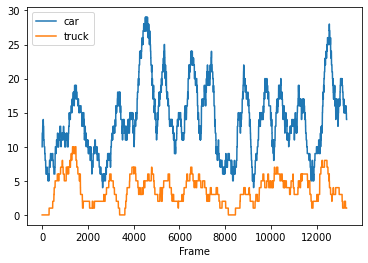

File id: 23


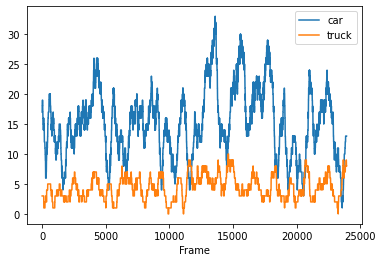

File id: 24


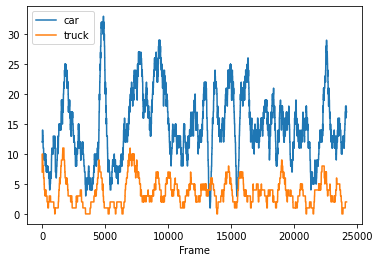

In [33]:
plot_traffic_density(config["H_highD_4_DEU"]["track_files"])

### highD_5 (location 6)

#### Trajectories

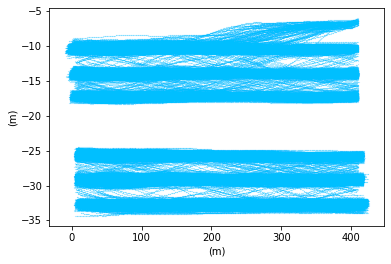

In [34]:
plot_trajectories(config["H_highD_5_DEU"]["track_files"])

#### Average Passing Time

Average passing time of the cars is 12.595 s.
Maximum passing time of the cars is 21.760 s.
STD of the cars' passing time is 2.050 s.
Average passing time of the trucks is 17.047 s.
Max passing time of the trucks is 24.440 s.
STD of the trucks' passing time is 1.661 s.


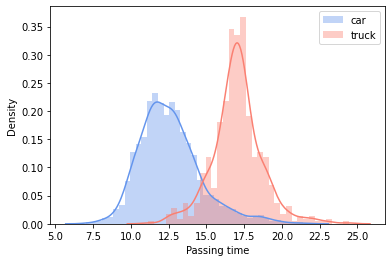

In [35]:
plot_passing_time(config["H_highD_5_DEU"]["track_files"])

#### Speed Distribution

Average speed of the cars is 32.036 s.
Maximum speed of the cars is 62.711 s.
Minimum speed of the cars is 62.711 s.
STD of the cars' speed is 5.157 s.
Average speed of the trucks is 23.081 s.
Maximum speed of the trucks is 52.002 s.
Minimum speed of the trucks is 52.002 s.
STD of the trucks speed is 2.311 s.


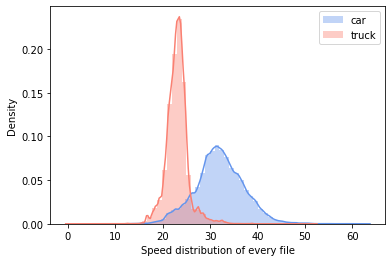

In [36]:
plot_speed_distribution(config["H_highD_5_DEU"]["track_files"])

#### Count Number of Lane Changing

In [37]:
count_lane_changing(config["H_highD_5_DEU"]["track_files"])

File id: 58 has 714 tracks in total.
	604 vehicles never changes lane.
	95 vehicles change lane for once.
	15 vehicles change lane for twice.
File id: 59 has 722 tracks in total.
	613 vehicles never changes lane.
	100 vehicles change lane for once.
	9 vehicles change lane for twice.
File id: 60 has 1467 tracks in total.
	1209 vehicles never changes lane.
	235 vehicles change lane for once.
	22 vehicles change lane for twice.


File id: 58


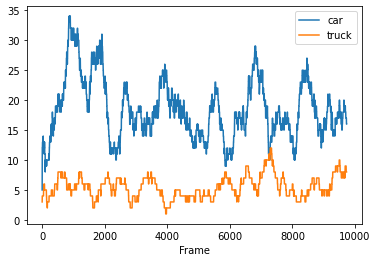

File id: 59


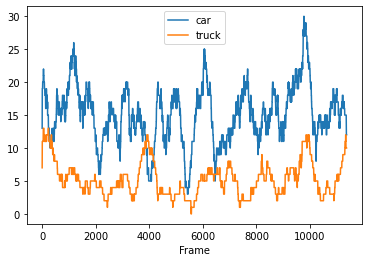

File id: 60


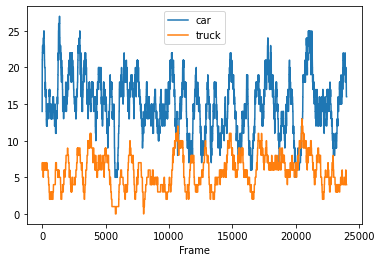

In [38]:
plot_traffic_density(config["H_highD_5_DEU"]["track_files"])